# Cassava Leaf Disease Classification

# 1. Importing packages and libraries

In [1]:
# Importing all the necessary packages to build and train the model
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.model_selection import train_test_split
import tensorflow.keras
from tensorflow.keras import applications
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import os
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Input, Dropout, Flatten, InputLayer, Dense, Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 2. Importing data and data preprocessing

In [2]:
# Importing the trainging image_id/ label sheet and image files from directory through ImageDataGenerator
traindf=pd.read_csv('train_1.csv',dtype=str)

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.1,
    horizontal_flip = True,
    vertical_flip = True,
    brightness_range=[1.0,1.25],
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split = 0.1)

batch_size = 64
img_size = 448

train_generator=train_datagen.flow_from_dataframe(
dataframe=traindf,
directory="train_imgs_1",
x_col="image_id",
y_col="label",
subset="training",
batch_size=batch_size,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))

valid_generator=train_datagen.flow_from_dataframe(
dataframe=traindf,
directory="train_imgs_1",
x_col="image_id",
y_col="label",
subset="validation",
batch_size=batch_size,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))

Found 15406 validated image filenames belonging to 5 classes.
Found 1711 validated image filenames belonging to 5 classes.


# 3. Transfer learning and fine tuning VGG16 model

In [3]:
# Transfer learning using pre-trained VGG16 weights
base_vgg = VGG16(
    weights='vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
    include_top = False,
    input_shape = (img_size, img_size, 3))

# Retaining the trained weights
for layer in base_vgg.layers:
    layer.trainable = False

# Fine tuning the output layers for better performance
x=base_vgg.output
x=GlobalMaxPooling2D()(x)
x=Dense(512, activation = "relu")(x)
x=Dropout(0.5)(x)
x=Dense(512, activation = "relu")(x)
x=Dropout(0.5)(x)
x=Dense(256, activation = "relu")(x)
x=Dropout(0.5)(x)
x=Dense(5, activation = "softmax")(x)

# Model compile
model = Model(base_vgg.input, x)
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 448, 448, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 448, 448, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 448, 448, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 224, 224, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 224, 224, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 224, 224, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 112, 112, 128)     0     

# 4. Training the model

In [4]:
# Training the model
epochs = 5
history = model.fit_generator(generator = train_generator,
                                validation_steps = valid_generator.n // batch_size,
                                validation_data = valid_generator,
                                steps_per_epoch = train_generator.n // batch_size,
                                epochs = epochs
                             )

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 240 steps, validate for 26 steps
Epoch 1/5
240/240 [==============================] - 915s 4s/step - loss: 1.3128 - accuracy: 0.5780 - val_loss: 1.0565 - val_accuracy: 0.6322
Epoch 2/5
240/240 [==============================] - 894s 4s/step - loss: 1.0840 - accuracy: 0.6195 - val_loss: 0.9539 - val_accuracy: 0.6569
Epoch 3/5
240/240 [==============================] - 894s 4s/step - loss: 1.0079 - accuracy: 0.6363 - val_loss: 0.9242 - val_accuracy: 0.6653
Epoch 4/5
240/240 [==============================] - 893s 4s/step - loss: 0.9751 - accuracy: 0.6470 - val_loss: 0.9097 - val_accuracy: 0.6707
Epoch 5/5
240/240 [==============================] - 893s 4s/step - loss: 0.9578 - accuracy: 0.6505 - val_loss: 0.9033 - val_accuracy: 0.6743


# 5. Unfreeze the convolutional layers

In [5]:
# Unfreezing the layers to update the weights
base_vgg.trainable=True
for layer in base_vgg.layers:
    layer.trainable = True
    
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 448, 448, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 448, 448, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 448, 448, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 224, 224, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 224, 224, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 224, 224, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 112, 112, 128)     0     

# 6. Re-training the model

In [6]:
# Re-training the model
epochs = 35
patience = 9 

# Callback functions
mc = ModelCheckpoint('dl_vgg16.h5', verbose=1, save_best_only=True)

es = EarlyStopping(
     monitor='val_loss',
     patience=patience,
     verbose=1,
     mode='auto',
     restore_best_weights=True)

# Training the model
history = model.fit_generator(generator = train_generator,
                                validation_steps = valid_generator.n // batch_size,
                                validation_data = valid_generator,
                                steps_per_epoch = train_generator.n // batch_size,
                                epochs = epochs,
                                callbacks = [es, mc]
                             )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 240 steps, validate for 26 steps
Epoch 1/35
239/240 [============================>.] - ETA: 3s - loss: 0.9647 - accuracy: 0.6483
Epoch 00001: val_loss improved from inf to 0.76813, saving model to dl_vgg16_m1_11_1.h5
240/240 [==============================] - 906s 4s/step - loss: 0.9638 - accuracy: 0.6487 - val_loss: 0.7681 - val_accuracy: 0.7109
Epoch 2/35
239/240 [============================>.] - ETA: 3s - loss: 0.7618 - accuracy: 0.7197
Epoch 00002: val_loss did not improve from 0.76813
240/240 [==============================] - 894s 4s/step - loss: 0.7613 - accuracy: 0.7199 - val_loss: 0.7815 - val_accuracy: 0.7025
Epoch 3/35
239/240 [============================>.] - ETA: 3s - loss: 0.6352 - accuracy: 0.7811
Epoch 00003: val_loss improved from 0.76813 to 0.54381, saving model to dl_vgg16_m1_11_1.h5
240/240 [==============================] - 894s 4s/step - loss: 0.6345 - accuracy: 0.7813 - val_loss: 0.5438 - val_accuracy:

# 7. 
## a. Importing the test images and predicting the test labels
## b. Updating the csv file with test labels for every image_id

In [7]:
# Importing sample_submission output file
test_label_file='test_labels.csv'
testdf=pd.read_csv(test_label_file,dtype=str)
testdf.label = testdf.label.astype('str')

test_datagen=ImageDataGenerator(rescale=1./255.)

# Importing the test image files
test_generator=test_datagen.flow_from_dataframe(
dataframe=testdf,
directory="test_imgs_1",
x_col="image_id",
y_col="label",
seed=42,
batch_size=batch_size,
shuffle=False,
class_mode='categorical',
target_size=(img_size,img_size))

steps=test_generator.n// batch_size +1
test_generator.reset()

# Predicting the test image files
pred=model.predict_generator(test_generator, steps=steps, verbose=1)

# Updating the output file with test labels 
testdf['label'] = pred.argmax(axis=1)
testdf.to_csv(test_label_file, index = False)

Found 4280 validated image filenames belonging to 1 classes.
Instructions for updating:
Please use Model.predict, which supports generators.
67/67 [==============================] - 58s 860ms/step


# 8. Plotting loss and accuracy graph against epochs

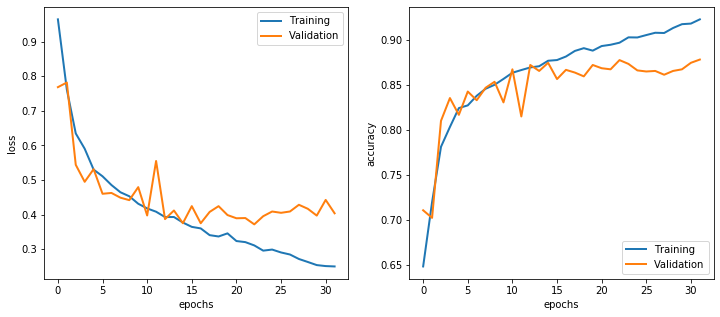

In [14]:
# Loss and Accuracy plot for both training and validation set
fig, axs = plt.subplots(1, 2 , figsize = (12,5))
axs[0].plot(range(len(history.history['loss'])), history.history['loss'], linewidth = 2, label = "Training")
axs[0].plot(range(len(history.history['loss'])), history.history['val_loss'], linewidth = 2, label = "Validation")
axs[0].set_xlabel("epochs")
axs[0].set_ylabel("loss")
axs[0].legend( loc='upper right')
axs[1].plot(range(len(history.history['accuracy'])), history.history['accuracy'], linewidth = 2, label = "Training")
axs[1].plot(range(len(history.history['accuracy'])), history.history['val_accuracy'], linewidth = 2, label = "Validation")
axs[1].set_xlabel("epochs")
axs[1].set_ylabel("accuracy")
axs[1].legend( loc='lower right')